<a href="https://colab.research.google.com/github/nyla111/machine-learning-31005/blob/main/ML_Week8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Load, split, scale

I used the Breast Cancer Wisconsin dataset, built into scikit-learn. Each row represents one patient’s tumor with 30 numeric features (like radius, smoothness, symmetry). The target is binary:

*   0 = malignant (cancerous)
*   1 = benign (not cancerous)

Before training Logistic Regression, I scaled the features with **StandardScaler** so all values have mean 0 and variance 1. This prevents features with larger numeric ranges from dominating.

In [3]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

data = load_breast_cancer()
X, y = data.data, data.target  # 0=malignant, 1=benign
scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# 2. Logistic Regression model



## 2.1 Hypothesis

We assume probability of class 1 (benign) is modeled by a sigmoid function of a linear combination:

$\hat{p}(y=1|x) = \sigma(w^T x + b), \quad \sigma(z) = \frac{1}{1+e^{-z}}$

This means the model takes input features, multiplies them by weights, adds a bias term, and then applies the sigmoid function to squash the output into a probability between 0 and 1.



## 2.2 Loss Function

To measure how well the model fits the data, we use the logistic (cross-entropy) loss:

$L = -\frac{1}{N}\sum_i \big[y_i \log(\hat{p}_i) + (1-y_i)\log(1-\hat{p}_i)\big]$

This loss penalizes the model more strongly when it makes confident but wrong predictions. If the model predicts 0.9 for a positive case, the loss is small; if it predicts 0.1 for a positive case, the loss is very large.




## 2.3 Optimizer
We train the model using gradient descent. The gradients of the loss with respect to the weights and bias show us how to adjust the parameters to reduce error. The update rules are:

$w := w - \eta \frac{\partial L}{\partial w}, \quad b := b - \eta \frac{\partial L}{\partial b}$

where $ \eta $ is the learning rate. Over many iterations, the model gradually improves by minimizing the loss.

In [ ]:
import numpy as np

class LogisticRegression:
    def __init__(self, lr=0.01, n_iter=1000):
        self.lr = lr
        self.n_iter = n_iter
        self.w = None
        self.b = None
        self.loss_history = []

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def compute_loss(self, y, y_pred):
        eps = 1e-9
        return -np.mean(y*np.log(y_pred+eps) + (1-y)*np.log(1-y_pred+eps))

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.w = np.zeros(n_features)
        self.b = 0

        for _ in range(self.n_iter):
            linear_model = np.dot(X, self.w) + self.b   # w^T x + b
            y_pred = self.sigmoid(linear_model)

            # Record loss
            loss = self.compute_loss(y, y_pred)
            self.loss_history.append(loss)

            # Gradient calculation
            dw = (1/n_samples) * np.dot(X.T, (y_pred - y))
            db = (1/n_samples) * np.sum(y_pred - y)

            # Update parameters
            self.w -= self.lr * dw
            self.b -= self.lr * db

    def predict_proba(self, X):
        linear_model = np.dot(X, self.w) + self.b
        y_pred = self.sigmoid(linear_model)
        return np.column_stack([1-y_pred, y_pred])  # [P(class 0), P(class 1)]

    def predict(self, X):
        probs = self.predict_proba(X)
        return (probs[:, 1] >= 0.5).astype(int)


# 3. Binary Loss and Criterions

## 3.1 Evaluation Metrics

In [ ]:
from sklearn.metrics import (
    accuracy_score, log_loss, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
)

# Train scratch model
model = LogisticRegression(lr=0.1, n_iter=1000)
model.fit(X_train, y_train)

# Predictions
probs = model.predict_proba(X_test)
preds = model.predict(X_test)

# Evaluation
print("Accuracy:", accuracy_score(y_test, preds))
print("Log Loss:", log_loss(y_test, probs))

# Additional metrics
print("Precision:", precision_score(y_test, preds))
print("Recall:", recall_score(y_test, preds))
print("F1-score:", f1_score(y_test, preds))
print("ROC AUC:", roc_auc_score(y_test, probs[:, 1]))

Accuracy: 0.9649122807017544
Log Loss: 0.08468648156873768
Precision: 0.9857142857142858
Recall: 0.9583333333333334
F1-score: 0.971830985915493
ROC AUC: 0.9957010582010581


The logistic regression model performed very well on the Breast Cancer Wisconsin dataset.

* Accuracy (96.5%): the majority of predictions were correct, but this metric alone does not capture the trade-off between false positives and false negatives.

* Log Loss (0.085): the predicted probabilities were well-calibrated, with the model assigning high confidence to correct predictions and low confidence to incorrect ones.

* Precision (98.6%): nearly all patients predicted as “benign” were truly benign, with minimal false alarms.

* Recall (95.8%): the model correctly identified most malignant cases, which is crucial in medical screening to avoid missed diagnoses.

* F1-score (97.2%): balances precision and recall, the model performs strongly on both fronts rather than excelling in just one.

* ROC AUC (0.996): good separability between malignant and benign cases across all possible thresholds.

## 3.2 Loss Curve

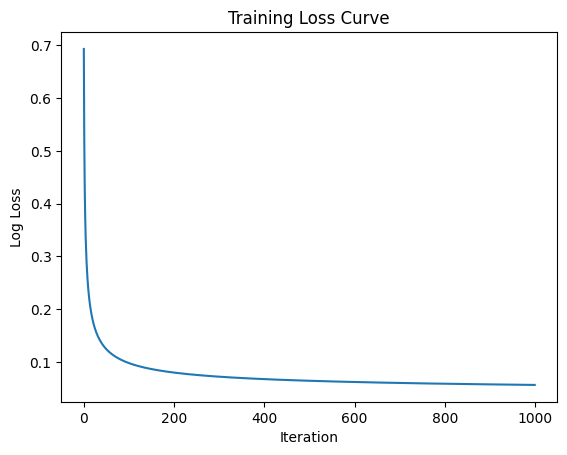

In [ ]:
import matplotlib.pyplot as plt

plt.plot(model.loss_history)
plt.xlabel("Iteration")
plt.ylabel("Log Loss")
plt.title("Training Loss Curve")
plt.show()

The training loss curve demonstrates stable convergence, with the loss decreasing smoothly and flattening out after ~200 iterations.

## 3.3 Confusion Matrix

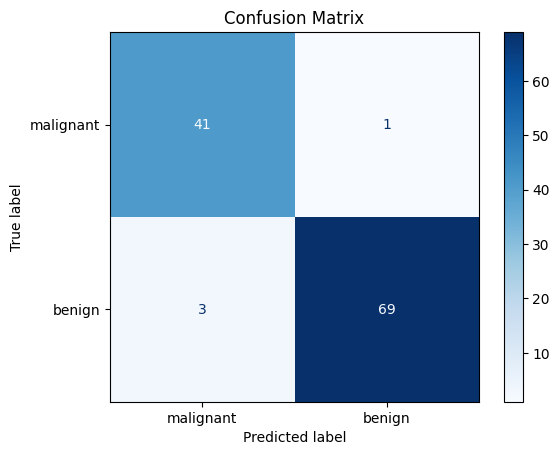

In [ ]:
cm = confusion_matrix(y_test, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=data.target_names)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

The confusion matrix breaking down TP/FP/FN/TN and shows that only 4 misclassifications out of 114 patients (1 false positive and 3 false negatives).

## 3.4 ROC AUC Curve

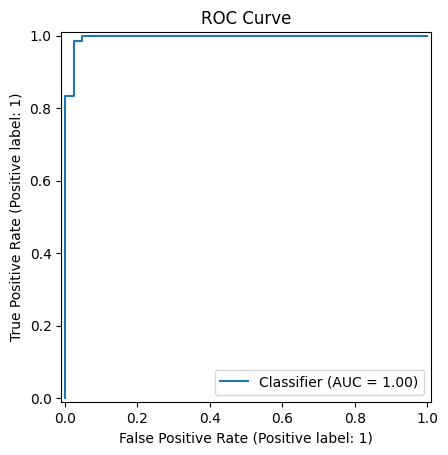

In [ ]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_predictions(y_test, probs[:, 1])
plt.title("ROC Curve")
plt.show()

The ROC curve also shows near-perfect performance, with the curve hugging the top-left corner and an AUC close to 1.0.

# 4. Multi-class Loss and Criterions


In [ ]:
import numpy as np

def softmax(logits):
    # logits: (N, K)
    m = logits.max(axis=1, keepdims=True)
    exps = np.exp(logits - m)
    return exps / exps.sum(axis=1, keepdims=True)

def cross_entropy_from_indices(logits, y_idx):
    # logits: (N, K), y_idx: (N,)
    m = logits.max(axis=1, keepdims=True)
    logsumexp = np.log(np.exp(logits - m).sum(axis=1, keepdims=True)) + m
    nll = (logsumexp.squeeze() - logits[np.arange(logits.shape[0]), y_idx])
    loss = nll.mean()
    # gradient w.r.t. logits
    p = softmax(logits)
    grad = p
    grad[np.arange(logits.shape[0]), y_idx] -= 1.0
    grad /= logits.shape[0]
    return loss, grad, p

def cross_entropy_from_onehot(logits, Y):
    # logits: (N, K), Y: one-hot (N, K)
    p = softmax(logits)
    eps = 1e-12
    loss = -(Y * np.log(p + eps)).sum(axis=1).mean()
    grad = (p - Y) / logits.shape[0]
    return loss, grad, p

In [ ]:
def step(X, y_idx, W, b, lr=1e-1):
    # X: (N,D), W: (D,K), b: (K,)
    logits = X @ W + b
    loss, grad_logits, p = cross_entropy_from_indices(logits, y_idx)
    # parameter grads
    dW = X.T @ grad_logits            # (D,K)
    db = grad_logits.sum(axis=0)      # (K,)
    W -= lr * dW
    b -= lr * db
    return loss, W, b, p

# 5. Model Family Experimenting

## 5.1 Randomly generated functions

In [ ]:
n_samples, n_features = X.shape
print(f"Dataset: {n_samples} samples, {n_features} features")

Dataset: 569 samples, 30 features


In [ ]:
np.random.seed(42)
n_functions = 100
n_features = X.shape[1]

functions = []
for i in range(n_functions):
    w = np.random.randn(n_features)
    b = np.random.randn()
    functions.append((w, b))

functions[0]

(array([ 0.49671415, -0.1382643 ,  0.64768854,  1.52302986, -0.23415337,
        -0.23413696,  1.57921282,  0.76743473, -0.46947439,  0.54256004,
        -0.46341769, -0.46572975,  0.24196227, -1.91328024, -1.72491783,
        -0.56228753, -1.01283112,  0.31424733, -0.90802408, -1.4123037 ,
         1.46564877, -0.2257763 ,  0.0675282 , -1.42474819, -0.54438272,
         0.11092259, -1.15099358,  0.37569802, -0.60063869, -0.29169375]),
 -0.6017066122293969)

## 5.2 Accuracy Statistics

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

results = []
all_preds = []

for w, b in functions:
    probs = sigmoid(np.dot(X, w) + b)
    preds = (probs >= 0.5).astype(int)
    acc = accuracy_score(y, preds)
    results.append(acc)
    all_preds.append(preds)

print(f"Average accuracy: {np.mean(results):.5f}")
print(f"Best accuracy: {np.max(results):.5f}")
print(f"Worst accuracy: {np.min(results):.5f}")

Average accuracy: 0.51216
Best accuracy: 0.75395
Worst accuracy: 0.24605


## 5.3 Similarity Between Functions

I used Hamming similarity = fraction of samples where two functions agree.

In [ ]:
all_preds = np.array(all_preds)  # shape (100, n_samples)
similarity_matrix = np.zeros((n_functions, n_functions))

for i in range(n_functions):
    for j in range(n_functions):
        similarity_matrix[i, j] = np.mean(all_preds[i] == all_preds[j])

print("Similarity among first 5 functions:")
similarity_matrix[:5, :5]


Similarity among first 5 functions:


array([[1.        , 0.08260105, 0.08260105, 0.08260105, 0.91739895],
       [0.08260105, 1.        , 1.        , 1.        , 0.        ],
       [0.08260105, 1.        , 1.        , 1.        , 0.        ],
       [0.08260105, 1.        , 1.        , 1.        , 0.        ],
       [0.91739895, 0.        , 0.        , 0.        , 1.        ]])

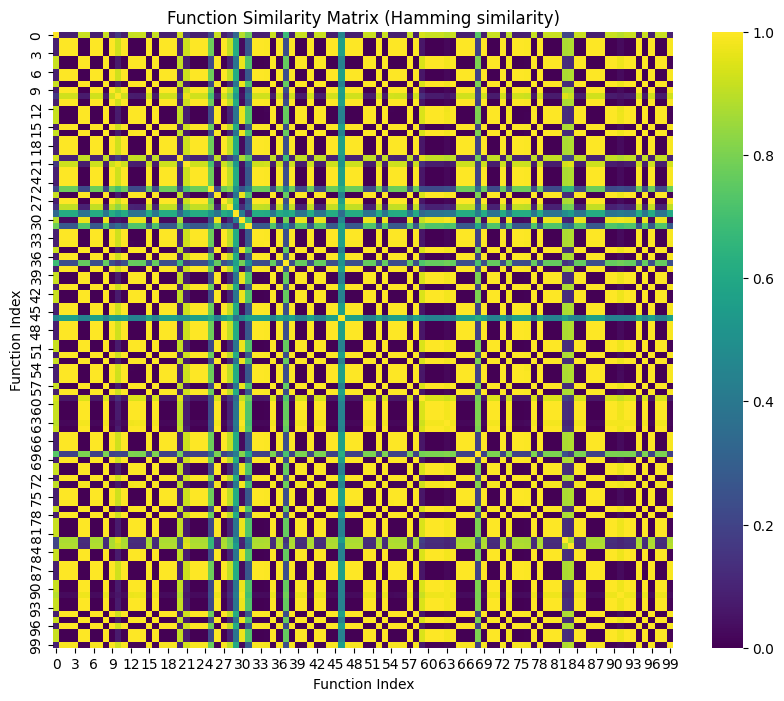

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix, cmap="viridis", cbar=True)
plt.title("Function Similarity Matrix (Hamming similarity)")
plt.xlabel("Function Index")
plt.ylabel("Function Index")
plt.show()

## 5.4 Compare One Function to the Others

I picked function with index 0 and check who is closest/farthest.

In [ ]:
f0_sims = similarity_matrix[0]

# Sort by similarity
closest_idx = np.argsort(f0_sims)[-5:]  # top 5 (most similar)
farthest_idx = np.argsort(f0_sims)[:5]  # bottom 5 (most different)

print("Function 0 is closest to:", closest_idx)
print("Function 0 is farthest from:", farthest_idx)

Function 0 is closest to: [80 98 20 59  0]
Function 0 is farthest from: [1 2 3 7 6]


## 5.5 Working with Larger Dataset (10,000 samples)

In [ ]:
from sklearn.datasets import make_classification

# Create synthetic dataset: 10,000 samples, 30 features
X_big, y_big = make_classification(
    n_samples=10000, n_features=X.shape[1],
    n_informative=20, n_redundant=5, n_classes=2,
    random_state=42
)

X_big_scaled = scaler.fit_transform(X_big)


Build 100 $\times$ 10,000 prediction matrix:

In [ ]:
# Prediction behavior of each random function across 10,000 examples
pred_matrix = np.zeros((n_functions, X_big_scaled.shape[0]), dtype=int)

for i, (w, b) in enumerate(functions):
    probs = sigmoid(np.dot(X_big_scaled, w) + b)
    preds = (probs >= 0.5).astype(int)
    pred_matrix[i] = preds

print("Prediction matrix shape:", pred_matrix.shape)  # (100, 10000)


Prediction matrix shape: (100, 10000)


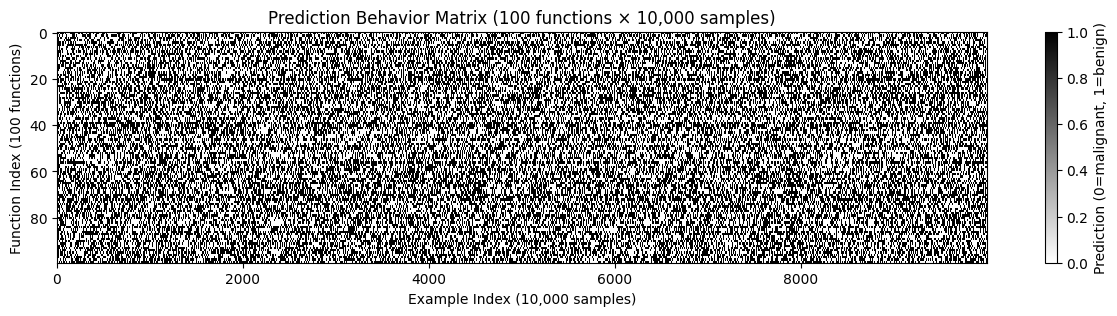

In [ ]:
plt.figure(figsize=(15, 3))
plt.imshow(pred_matrix, aspect='auto', cmap='binary', interpolation='nearest')
plt.colorbar(label="Prediction (0=malignant, 1=benign)")
plt.xlabel("Example Index (10,000 samples)")
plt.ylabel("Function Index (100 functions)")
plt.title("Prediction Behavior Matrix (100 functions × 10,000 samples)")
plt.show()

Then I analyze inter-function differences by computing pairwise Hamming similarities:

In [ ]:
sim_matrix_big = np.zeros((n_functions, n_functions))

for i in range(n_functions):
    for j in range(n_functions):
        sim_matrix_big[i, j] = np.mean(pred_matrix[i] == pred_matrix[j])

print("Similarity among first 5 functions (big dataset):")
print(sim_matrix_big[:5, :5])


Similarity among first 5 functions (big dataset):
[[1.     0.5198 0.5536 0.4914 0.4809]
 [0.5198 1.     0.4508 0.4602 0.5723]
 [0.5536 0.4508 1.     0.5832 0.4963]
 [0.4914 0.4602 0.5832 1.     0.4673]
 [0.4809 0.5723 0.4963 0.4673 1.    ]]


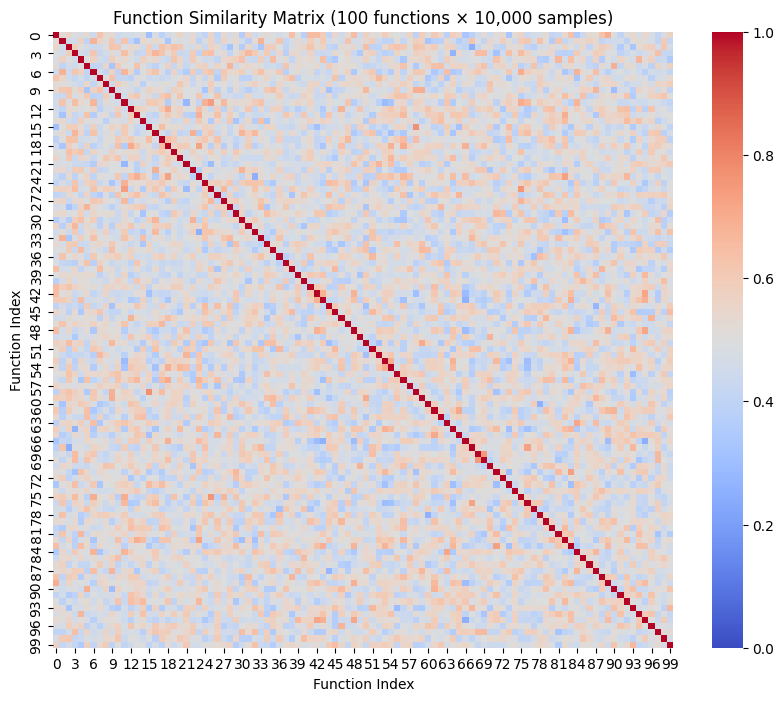

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(sim_matrix_big, cmap="coolwarm", cbar=True, vmin=0, vmax=1)
plt.title("Function Similarity Matrix (100 functions × 10,000 samples)")
plt.xlabel("Function Index")
plt.ylabel("Function Index")
plt.show()

# Neural Network


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

In [4]:
# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

In [5]:
# Define small NN model
class MLP(nn.Module):
    def __init__(self, input_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, 16)   # hidden layer 1
        self.fc2 = nn.Linear(16, 8)           # hidden layer 2
        self.fc3 = nn.Linear(8, 1)            # output layer
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)        # regularization
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return self.sigmoid(x)

model = MLP(input_dim=X_train.shape[1])

In [6]:
# Loss & optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


# Training loop
epochs = 50
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

Epoch 10/50, Loss: 0.6618
Epoch 20/50, Loss: 0.6396
Epoch 30/50, Loss: 0.6043
Epoch 40/50, Loss: 0.5659
Epoch 50/50, Loss: 0.5211


In [8]:
from sklearn.metrics import accuracy_score

# Evaluation
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor)
    y_pred_class = (y_pred >= 0.5).float()
    acc = accuracy_score(y_test, y_pred_class.numpy())
    print(f"Neural Network Test Accuracy: {acc:.4f}")

Neural Network Test Accuracy: 0.9211
